In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
torch.randn(5).cuda()

tensor([-0.3823,  0.8951, -0.0168,  1.3003, -0.0166], device='cuda:0')

In [ ]:
model = nn.Sequential(
    nn.Linear(28*28, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10) #10 is the output of the classifier: 0-9
)

## Optimizer
We can choose Adam or SGD...

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Loss function
We use cross entropy here(since we are in multi-class classification).
In other scenarios, torch.nn.MSELoss() can be used continuos output regressions (house price predictions), torch.nn.BCELoss() for binary cases...

In [ ]:
Loss = nn.CrossEntropyLoss()

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define a transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST training dataset
train_val_dataset = datasets.MNIST(
    root='./data',  # Path where the data will be stored
    train=True,     # Load the training data
    download=True,  # Download the data if it's not already available
    transform=transform  # Apply the defined transform
)

# Split the dataset into train and validation sets with specific sizes
train_dataset, val_dataset = random_split(train_val_dataset, [55000, 5000])

# Create DataLoaders for both train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation data

## Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
model.to(device)
Loss.to(device)

CrossEntropyLoss()

Epoch: 1, Train Loss: 1.9663, Validation Loss: 1.4299, Validation Accuracy: 71.76%


Epoch: 2, Train Loss: 0.9478, Validation Loss: 0.6687, Validation Accuracy: 83.98%


Epoch: 3, Train Loss: 0.5559, Validation Loss: 0.4907, Validation Accuracy: 86.62%


Epoch: 4, Train Loss: 0.4421, Validation Loss: 0.4161, Validation Accuracy: 88.12%


Epoch: 5, Train Loss: 0.3869, Validation Loss: 0.3744, Validation Accuracy: 89.36%


Epoch: 6, Train Loss: 0.3538, Validation Loss: 0.3484, Validation Accuracy: 89.96%


Epoch: 7, Train Loss: 0.3316, Validation Loss: 0.3304, Validation Accuracy: 90.40%


Epoch: 8, Train Loss: 0.3147, Validation Loss: 0.3157, Validation Accuracy: 90.74%


Epoch: 9, Train Loss: 0.3011, Validation Loss: 0.3045, Validation Accuracy: 90.96%


Epoch: 10, Train Loss: 0.2895, Validation Loss: 0.2938, Validation Accuracy: 91.46%


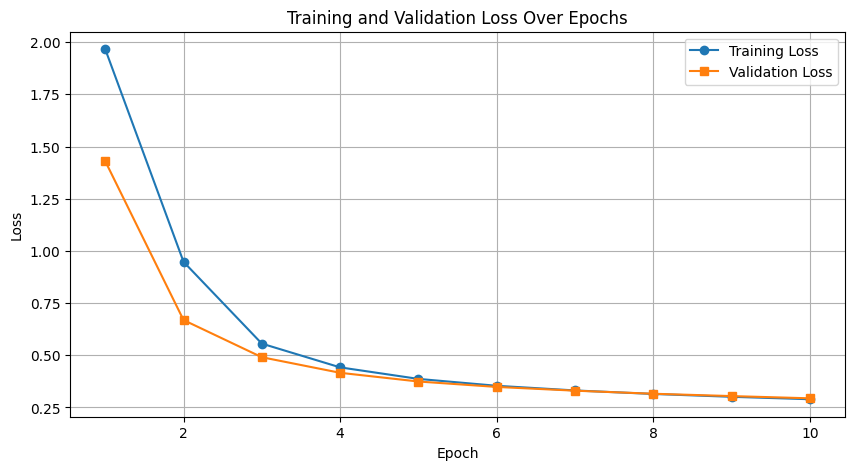

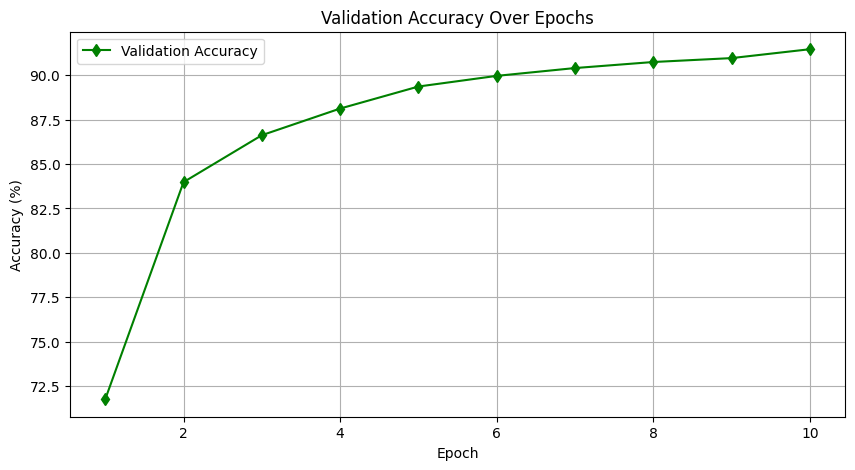

In [ ]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and loss function to the selected device
model.to(device)
Loss.to(device)

# Initialize variables to store losses and accuracy
train_losses = []
val_losses = []
val_accuracies = []

N_epochs = 10

for epoch in range(N_epochs):
    model.train()  # Set the model to training mode
    epoch_train_loss = 0  # Accumulator for training loss

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{N_epochs}", leave=False):
        x, y = batch
        x = x.to(device)  # Move x to GPU
        y = y.to(device)  # Move y to GPU

        b = x.size(0)
        x = x.view(b, -1)

        # 1. Forward
        l = model(x)  # Forward pass: compute logits

        # 2. Compute the objective function
        J = Loss(l, y)

        # 3. Clean up the gradient
        model.zero_grad()

        # 4. Accumulate the partial derivatives
        J.backward()

        # 5. Step in the opposite direction of the gradient
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_train_loss += J.item()

    # Average training loss for this epoch
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0  # Accumulator for validation loss
    correct = 0  # Correct predictions count
    total = 0  # Total samples count

    with torch.no_grad():  # Disable gradient calculations for validation
        for batch in val_loader:
            x_val, y_val = batch
            x_val = x_val.to(device)  # Move x_val to GPU
            y_val = y_val.to(device)  # Move y_val to GPU

            b_val = x_val.size(0)
            x_val = x_val.view(b_val, -1)

            # 1. Forward (model predictions)
            l_val = model(x_val)

            # 2. Calculate loss
            J_val = Loss(l_val, y_val)
            epoch_val_loss += J_val.item()

            # Calculate accuracy
            _, predicted = torch.max(l_val.data, 1)  # Get predicted class labels
            total += y_val.size(0)  # Increment total samples count
            correct += (predicted == y_val).sum().item()  # Increment correct predictions count

    # Average validation loss and accuracy for this epoch
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracy = 100 * correct / total  # Calculate validation accuracy
    val_accuracies.append(val_accuracy)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, N_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_epochs + 1), val_accuracies, label="Validation Accuracy", marker='d', color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Residual Layer
We add a residual to avoid gradient vanishing!
This is the basic of ResNet!

In [ ]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 64)  # First layer
        self.l2 = nn.Linear(64, 64)      # Second layer
        self.l3 = nn.Linear(64, 10)      # Output layer
        self.do = nn.Dropout(0.1)        # Dropout with 10% probability

    def forward(self, x):
        h1 = nn.functional.relu(self.l1(x))  # First hidden layer
        h2 = nn.functional.relu(self.l2(h1)) # Second hidden layer
        d = self.do(h2 + h1)  # Residual connection and dropout
        logits = self.l3(d)   # Final output layer
        return logits

# Instantiate the model
model_resnet = ResNet()

# Define the optimizer
params = model_resnet.parameters()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet.to(device)

ResNet(
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=10, bias=True)
  (do): Dropout(p=0.1, inplace=False)
)

In [ ]:
Loss.to(device)

CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-3)

In [ ]:
# Define a transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST training dataset
train_val_dataset = datasets.MNIST(
    root='./data',  # Path where the data will be stored
    train=True,     # Load the training data
    download=True,  # Download the data if it's not already available
    transform=transform  # Apply the defined transform
)

# Split the dataset into train and validation sets with specific sizes
train_dataset, val_dataset = random_split(train_val_dataset, [55000, 5000])

# Create DataLoaders for both train and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation data

Epoch: 1, Train Loss: 0.2707, Validation Loss: 0.1578, Validation Accuracy: 95.32%


Epoch: 2, Train Loss: 0.1300, Validation Loss: 0.1228, Validation Accuracy: 96.10%


Epoch: 3, Train Loss: 0.0979, Validation Loss: 0.1025, Validation Accuracy: 96.62%


Epoch: 4, Train Loss: 0.0837, Validation Loss: 0.1063, Validation Accuracy: 96.88%


Epoch: 5, Train Loss: 0.0729, Validation Loss: 0.0964, Validation Accuracy: 96.96%


Epoch: 6, Train Loss: 0.0648, Validation Loss: 0.0951, Validation Accuracy: 97.34%


Epoch: 7, Train Loss: 0.0547, Validation Loss: 0.1052, Validation Accuracy: 97.08%


Epoch: 8, Train Loss: 0.0505, Validation Loss: 0.1085, Validation Accuracy: 97.12%


Epoch: 9, Train Loss: 0.0472, Validation Loss: 0.1184, Validation Accuracy: 97.30%


Epoch: 10, Train Loss: 0.0454, Validation Loss: 0.1058, Validation Accuracy: 97.66%


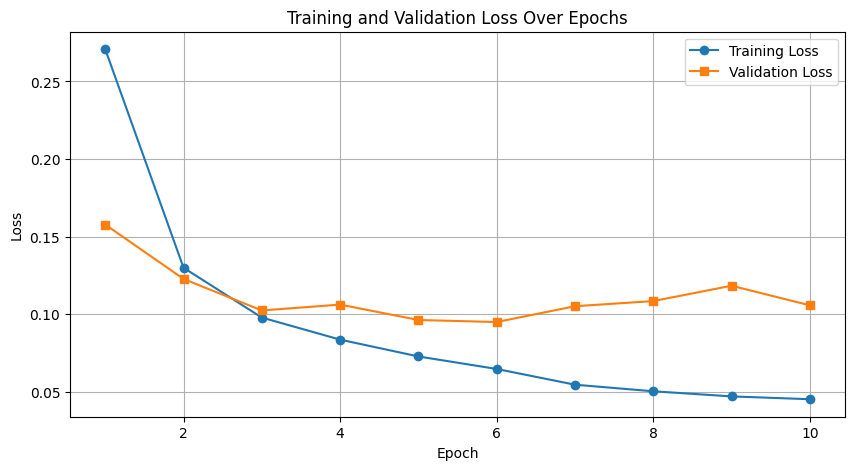

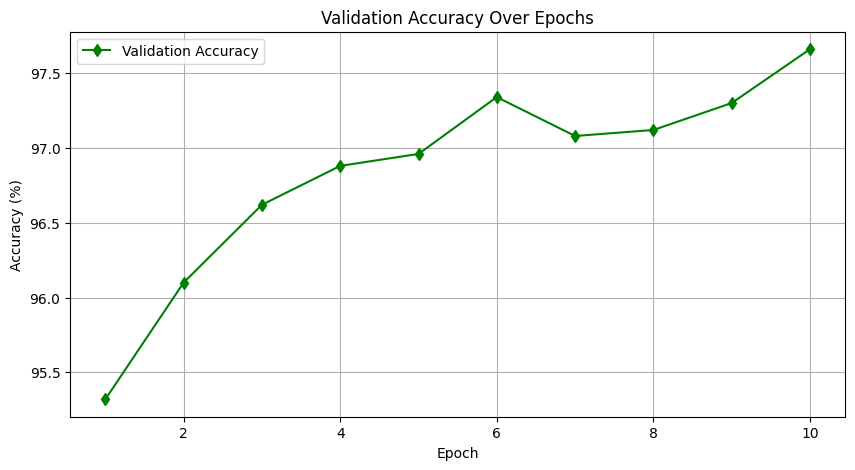

In [ ]:
# Initialize variables to store losses and accuracy
train_losses = []
val_losses = []
val_accuracies = []

N_epochs = 10

for epoch in range(N_epochs):
    model_resnet.train()  # Set the model to training mode
    epoch_train_loss = 0  # Accumulator for training loss

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{N_epochs}", leave=False):
        x, y = batch
        x = x.to(device)  # Move x to GPU
        y = y.to(device)  # Move y to GPU

        b = x.size(0)
        x = x.view(b, -1)

        # 1. Forward
        l = model_resnet(x)  # Forward pass: compute logits

        # 2. Compute the objective function
        J = Loss(l, y)

        # 3. Clean up the gradient
        model_resnet.zero_grad()

        # 4. Accumulate the partial derivatives
        J.backward()

        # 5. Step in the opposite direction of the gradient
        optimizer.step()

        # Accumulate the loss for this batch
        epoch_train_loss += J.item()

    # Average training loss for this epoch
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validation phase
    model_resnet.eval()  # Set the model to evaluation mode
    epoch_val_loss = 0  # Accumulator for validation loss
    correct = 0  # Correct predictions count
    total = 0  # Total samples count

    with torch.no_grad():  # Disable gradient calculations for validation
        for batch in val_loader:
            x_val, y_val = batch
            x_val = x_val.to(device)  # Move x_val to GPU
            y_val = y_val.to(device)  # Move y_val to GPU

            b_val = x_val.size(0)
            x_val = x_val.view(b_val, -1)

            # 1. Forward (model predictions)
            l_val = model_resnet(x_val)

            # 2. Calculate loss
            J_val = Loss(l_val, y_val)
            epoch_val_loss += J_val.item()

            # Calculate accuracy
            _, predicted = torch.max(l_val.data, 1)  # Get predicted class labels
            total += y_val.size(0)  # Increment total samples count
            correct += (predicted == y_val).sum().item()  # Increment correct predictions count

    # Average validation loss and accuracy for this epoch
    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracy = 100 * correct / total  # Calculate validation accuracy
    val_accuracies.append(val_accuracy)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, N_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, N_epochs + 1), val_accuracies, label="Validation Accuracy", marker='d', color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()